**Sentiment Analysis based on Tweet dataset**

In [ ]:
''' install required libraries '''

!pip install textblob
!pip install nltk
!pip install wordcloud
!pip install tweepy
!pip install langdetect

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas as pd
import re ,string, csv

import tweepy # to access tweet API
from tweepy import OAuthHandler # for Authentication

from textblob import TextBlob #for Valance of Sentence(polarity)

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
# nltk.download('all') # Installing All from NLTK library
from nltk.corpus import stopwords # For Removing Stop words like < the , an , is ,..etc >
n_words= stopwords.words('english') #specify english stop words only
n_words.append("rt") #append rt for stop word dictionary

from nltk.tokenize import word_tokenize # for Tokenizing the sentnces as tokens
from nltk.stem.porter import PorterStemmer # converting words to their root forms ,speed and simplicity
porter = PorterStemmer() #Create stemmer obejct

from nltk.stem import WordNetLemmatizer # also converting words to their actual root forms(noun , verb ,aobjective) ,but it slow
lemmatizer = WordNetLemmatizer() #Create lemmatizer obejct

from wordcloud import WordCloud,STOPWORDS #Look at Words with highest Frequency for expression

from langdetect import detect_langs # Detect language for each tweets 

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk import ngrams
from sklearn.model_selection import train_test_split
import time
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Reading Datasets
# stocks=pd.read_csv("/content/stocks_cleaned.csv")
Data=pd.read_csv("/content/Startup_tweets.csv",error_bad_lines=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      500 non-null    int64 
 1   text    500 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [ ]:
'''Convert Columns data types '''

# stockerbot["timestamp"] = pd.to_datetime(stockerbot["timestamp"])
Data["text"] = Data["text"].astype(str)
# Data["url"] = Data["url"].astype(str)
# Data["company_names"] = Data["company_names"].astype("category")
# Data["symbols"] = Data["symbols"].astype("category")
# Data["source"] = Data["source"].astype("category")
Data=Data.drop(columns=['id'])

In [ ]:
''' Split Timestamp Column into Dates and times '''

# Data[['dayofweek','month','day','time','timezone', 'year']] = Data.timestamp.str.split(expand=True)
# Data[['hour','minute','second']] = Data.time.str.split(':',expand=True)
# Data.head(4)

' Split Timestamp Column into Dates and times '

In [ ]:
''' Check for null values '''
Data.isnull().any() 

text    False
dtype: bool

In [ ]:
# ''' Check for null values in Company names columns '''

# print(f'null :{Data.company_names.isnull().sum()}')
# Data[Data['company_names'].isnull()] 

In [ ]:
# Define Clean Function to fix text
def Clean(text):

  # Frist converting all letters to lower case
  text= text.lower()
  
  # removing unwanted digits ,special chracters from the text
  text= ' '.join(re.sub("(@[A-Za-z0-9]+)", " ", text).split()) #tags
  text= ' '.join(re.sub("^@?(\w){1,15}$", " ", text).split())
    
  text= ' '.join(re.sub("(\w+:\/\/\S+)", " ", text).split())   #Links
  text= ' '.join(re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"," ", text).split()) 
  text= ' '.join(re.sub(r'http\S+', '',text).split())
  
  
  text= ' '.join(re.sub(r'www\S+', '',text).split())
  text= ' '.join(re.sub("\s+", " ",text).split()) #Extrem white Space
  text= ' '.join(re.sub("[^-9A-Za-z ]", "" ,text).split()) #digits 
  text= ' '.join(re.sub('-', ' ', text).split()) 
  text= ' '.join(re.sub('_', ' ', text).split()) #underscore 
  
  # Display available PUNCTUATION for examples
  #for c in string.punctuation:
       #print(f"[{c}]")
  
  # removing stopwards and numbers from STRING library
  table= str.maketrans('', '', string.punctuation+string.digits)
  text = text.translate(table)
  
  # Split Sentence as tokens words 
  tokens = word_tokenize(text)
  
  # converting words to their root forms by STEMMING THE WORDS 
#   stemmed1 = [lemmatizer.lemmatize(word) for word in tokens] #Covert words to their actual root
  stemmed2 = [porter.stem(word) for word in tokens] # Covert words to their rootbut not actual
  
  # Delete each stop words from English stop words
#   words = [w for w in stemmed1 if not w in n_words] #n_words contains English stop words
  words = [w for w in stemmed2 if not w in n_words] #n_words contains English stop words

  text  = ' '.join(words)
    
  return text

In [ ]:
# Text Before Pre-processing
Data.text

0      RT @Fantom_Space: 🔵 @BakerGuild Epic Yield-far...
1      RT @stpiindia: CLARILA Technologies Pvt. Ltd.,...
2      RT @Fantom_Space: 🔵 @BakerGuild Epic Yield-far...
3      RT @stpiindia: Vi INNOVATIONS, a startup focus...
4      @Indiegogo I will promote gofundme fundraising...
                             ...                        
495    Thank you @techinasia for the feature. We are ...
496    RT @TidurBeruang1: Startup makin besar biarpun...
497    RT @Missypromotes: $100 GIVEAWAY 💰\n\n- retwee...
498    RT @StroutMotivateU: Want unparalleled custome...
499    RT @Omkar_Raii: India’s total tally of unicorn...
Name: text, Length: 500, dtype: object

In [ ]:
#Delete unwanted source form our text 
#Data=Data[Data["source"] != "test5f1798"]

In [ ]:
# apply Clean Funsction to our Text
Data.text=[Clean(x) for x in Data.text]
# Delete Unwanted Some Text 
Data=Data[Data["text"]!='btc']

In [ ]:
# Text after Pre-processing
Data.text

0      space epic yield farm fantom main featur divid...
1      clarila technolog pvt ltd edtech startup focus...
2      space epic yield farm fantom main featur divid...
3      vi innov startup focus develop solut connect e...
4      promot gofundm fundrais crowdfund campaign kic...
                             ...                        
495    thank featur super grate everyon ha part journ...
496    startup makin besar biarpun udah berond fund t...
497       giveaway retweet amp follow end hour whitelist
498    want unparallel custom servic earli adopt startup
499    raii india total talli unicorn reach total val...
Name: text, Length: 500, dtype: object

In [ ]:
''' Detect Emotions for each text Form TextBlob Library '''

detectEmotion=[]
detectPolarity=[]

for txt in Data.text:
    
    analysis=TextBlob(txt)
    Polarity=analysis.sentiment.polarity
    
    if Polarity  <0:
        emotion='2'  #Negative
    elif Polarity>0: 
        emotion='1'  #Positive
    else:
        emotion='0'  #Neutral
        
    detectEmotion.append(emotion)
    detectPolarity.append(Polarity)
    
# detectEmotion=pd.DataFrame()

Data['Polarity']=detectPolarity
Data['Emotion'] =detectEmotion

In [ ]:
#check for valid string only to detect languages

TextValid=[]

for i in range(len(Data)):
    TextValid.append(bool(re.match('^(?=.*[a-zA-Z])', Data.iloc[i,0])))
    
Data['valid']=TextValid
print(len(Data[Data['valid']==False]))
print(len(Data[Data['valid']==True]))

2
498


In [ ]:
# valid string only

Data=Data[Data['valid']==True]

In [ ]:
'''Detect languages for each text to filter into specific Lang'''

languages = []

# Loop over the sentences in the data and detect their language
for row in range(len(Data)):
    languages.append(detect_langs(Data.iloc[row, 0]))
    
# print('The detected languages are: ', languages) >>> ['en':'N']
languages = [str(lang).split(':')[0][1:] for lang in languages] 

# Assign the list to a new feature 
Data['language'] = languages

In [ ]:
# look at Lang detected from our text

Data['language'].value_counts()

en    422
ro     17
it     12
da      7
nl      6
de      6
sv      4
id      3
fr      3
hr      3
tl      2
et      2
ca      2
no      2
fi      1
es      1
pl      1
lt      1
tr      1
pt      1
sl      1
Name: language, dtype: int64

In [ ]:
# We Only want to deal with english text for now , so we will filter data for EN Only

Data=Data[Data['language']=='en']

In [ ]:
Data=Data[['text','Polarity','Emotion','language']]
Data.head(4)

,text,Polarity,Emotion,language
0,space epic yield farm fantom main featur divid...,0.133333,1,en
1,clarila technolog pvt ltd edtech startup focus...,0.000000,0,en
2,space epic yield farm fantom main featur divid...,0.133333,1,en
4,promot gofundm fundrais crowdfund campaign kic...,0.500000,1,en


In [ ]:
# the below function will create a word cloud

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word  # double check for nay links
                                and not word.startswith('#')  # removing hash tags
                                and word != 'rt'  
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS, # using stopwords provided by Word cloud its optional since we already removed stopwords :)
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    # using matplotlib to display the images in notebook itself.
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
  

In [ ]:
# Percentage of each Emotions overall symbols

df_neutral   = Data['text'][ Data['Emotion'] == '0']
df_positive  = Data['text'][ Data['Emotion'] == '1']
df_negative  = Data['text'][ Data['Emotion'] == '2']


print(f' Percentage Positive: {len(df_positive)/len(Data)}\n Percentage Negetive: {len(df_negative)/len(Data)}\n Percentage Neutral: {len(df_neutral)/len(Data)}')

 Percentage Positive: 0.2725118483412322
 Percentage Negetive: 0.05924170616113744
 Percentage Neutral: 0.6682464454976303


Most Positive words Frequency


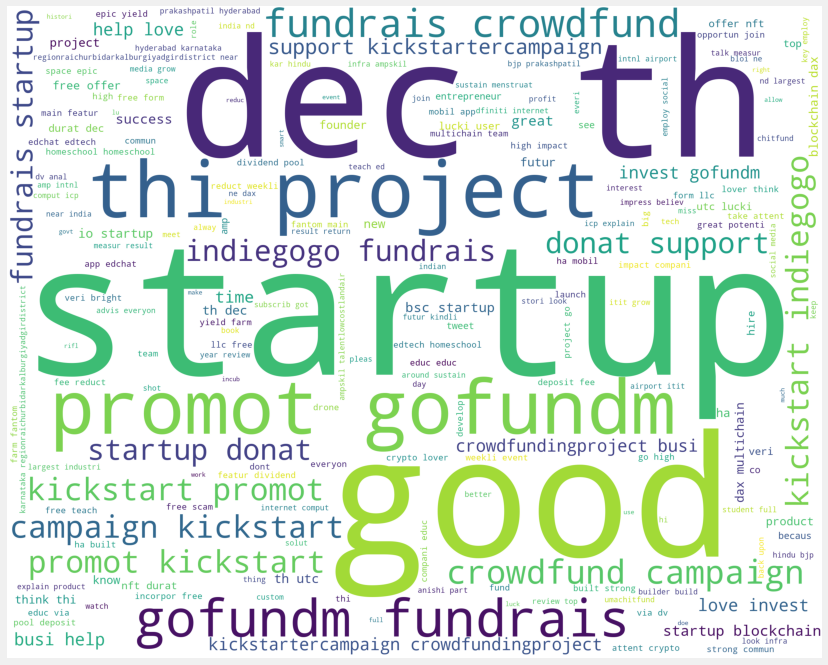

Most Negative words Frequency


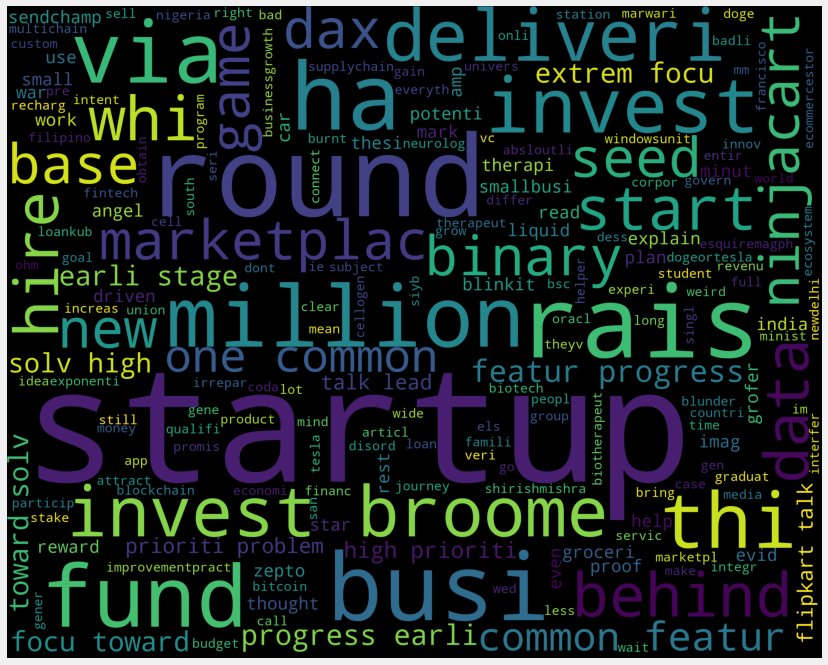

Most Neutral words Frequency


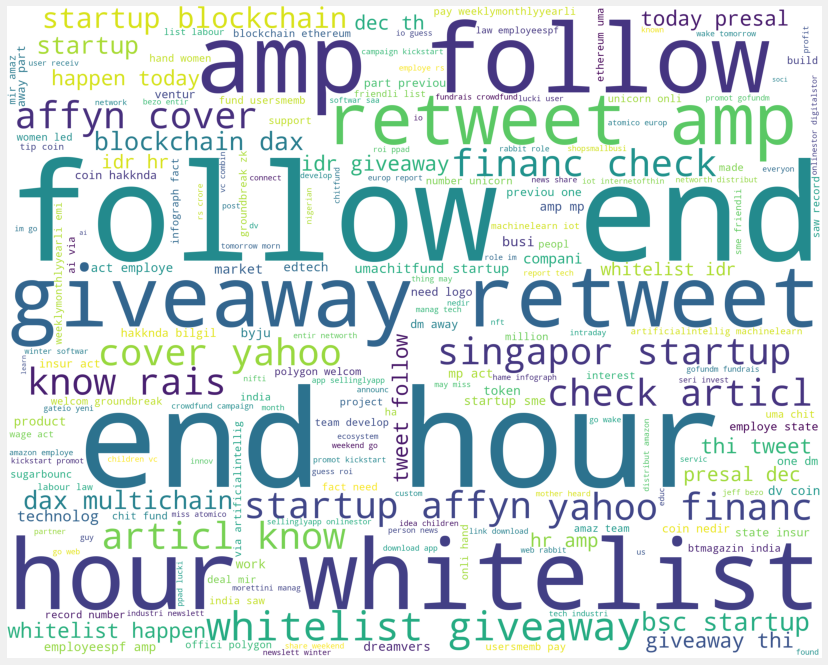

In [ ]:
print("Most Positive words Frequency")
wordcloud_draw(df_positive, 'white')
print("Most Negative words Frequency")
wordcloud_draw(df_negative)
print("Most Neutral words Frequency")
wordcloud_draw(df_neutral, 'white')

In [ ]:
def NgramModels(Model , txt, n):
    
    x_train, x_test, y_train, y_test = train_test_split(Data['text'], Data['Emotion'], test_size=0.2, random_state=50)
    
    vect      = CountVectorizer(max_features=1000 , ngram_range=(n,n))
    train_vect= vect.fit_transform(x_train)
    test_vect = vect.transform(x_test)
    
    model     = Model
    t0        = time.time()
    model.fit(train_vect, y_train)
    t1        = time.time()
    predicted = model.predict(test_vect)
    t2        = time.time()
    time_train= t1-t0
    time_pred = t2-t1
    
    accuracy  = model.score(train_vect, y_train)
    predicted = model.predict(test_vect)
    
    report = classification_report(y_test, predicted, output_dict=True)
    print("Models with " , n , "-grams :\n")
    print('********************** \n')
    print(txt)
    print("Training time: %fs; Prediction time: %fs \n" % (time_train, time_pred))
    print('Accuracy score train set :', accuracy)
    print('Accuracy score test set  :', accuracy_score(y_test, predicted),'\n')
    print('Positive: ', report['1'])
    print('Neutral : ', report['0'])
    print('Negative: ', report['2'])
    print('\n --------------------------------------------------------------------------------------------------- \n')

In [ ]:
def KNN_Ngram(n):
    
    x_train, x_test, y_train, y_test = train_test_split(Data['text'], Data['Emotion'], test_size=0.2, random_state=50)
    
    vect      = CountVectorizer(max_features=1000 , ngram_range=(n,n))
    train_vect= vect.fit_transform(x_train)
    test_vect = vect.transform(x_test)
    
    for k in [1,3,5,7,10]:

        model = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
        t0        = time.time()
        model.fit(train_vect, y_train)
        t1        = time.time()
        predicted = model.predict(test_vect)
        t2        = time.time()
        time_train= t1-t0
        time_pred = t2-t1

        accuracy  = model.score(train_vect, y_train)
        predicted = model.predict(test_vect)

        report = classification_report(y_test, predicted, output_dict=True)

        print("Models with " , n , "-grams :\n")
        print('********************** \n')
        print("Classification Report for k = {} is:\n".format(k))
        print("Training time: %fs ; Prediction time: %fs \n" % (time_train, time_pred))
        print('Accuracy score train set :', accuracy)
        print('Accuracy score test set  :', accuracy_score(y_test, predicted),'\n')
        print('Positive: ', report['1'])
        print('Neutral : ', report['0'])
        print('Negative: ', report['2'])
        print('\n -------------------------------------------------------------------------------------- \n')

In [ ]:
def TFIDFModels(Model,txt):
    
    x_train, x_test, y_train, y_test = train_test_split(Data['text'], Data['Emotion'], test_size=0.2, random_state=50)
    
    vect      = TfidfVectorizer(min_df = 5, max_df =0.8, sublinear_tf = True, use_idf = True)
    train_vect= vect.fit_transform(x_train)
    test_vect = vect.transform(x_test)
    
    model     = Model
    t0        = time.time()
    model.fit(train_vect, y_train)
    t1        = time.time()
    predicted = model.predict(test_vect)
    t2        = time.time()
    time_train= t1-t0
    time_pred = t2-t1
    
    accuracy  = model.score(train_vect, y_train)
    predicted = model.predict(test_vect)
    
    report = classification_report(y_test, predicted, output_dict=True)
    
    print(txt)
    print("Training time: %fs; Prediction time: %fs \n" % (time_train, time_pred))
    print('Accuracy score train set :', accuracy)
    print('Accuracy score test set  :', accuracy_score(y_test, predicted),'\n')
    print('Positive: ', report['1'])
    print('Neutral : ', report['0'])
    print('Negative: ', report['2'])
    print('\n -------------------------------------------------------------------------------------- \n')

In [ ]:
def KNN_TFIDF():
    
    x_train, x_test, y_train, y_test = train_test_split(Data['text'], Data['Emotion'], test_size=0.2, random_state=50)
    
    vect      = TfidfVectorizer(min_df = 5, max_df =0.8, sublinear_tf = True, use_idf = True)
    train_vect= vect.fit_transform(x_train)
    test_vect = vect.transform(x_test)
    
    for k in [1,3,5,7,10]:

        model = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
        t0        = time.time()
        model.fit(train_vect, y_train)
        t1        = time.time()
        predicted = model.predict(test_vect)
        t2        = time.time()
        time_train= t1-t0
        time_pred = t2-t1

        accuracy  = model.score(train_vect, y_train)
        predicted = model.predict(test_vect)

        report = classification_report(y_test, predicted, output_dict=True)

        print("Classification Report for k = {} is:\n".format(k))
        print("Training time: %fs ; Prediction time: %fs \n" % (time_train, time_pred))
        print('Accuracy score train set :', accuracy)
        print('Accuracy score test set  :', accuracy_score(y_test, predicted),'\n')
        print('Positive: ', report['1'])
        print('Neutral : ', report['0'])
        print('Negative: ', report['2'])
        print('\n -------------------------------------------------------------------------------------- \n')

In [ ]:
SupportVectorClassifier=svm.SVC(kernel='linear')

LogReg2=NgramModels(Model=LogisticRegression(),txt='Logistic Regression Model : \n ', n=2)
LogReg3=NgramModels(Model=LogisticRegression(),txt='Logistic Regression Model : \n ', n=3)

svm2=NgramModels(Model=SupportVectorClassifier ,txt='Support Vectoer Classifier Model : \n ', n=2)
svm3=NgramModels(Model=SupportVectorClassifier ,txt='Support Vectoer Classifier Model : \n ', n=3)

DecTree2=NgramModels(Model=tree.DecisionTreeClassifier(),txt='Decision Tree Classifier Model : \n ', n=2)
DecTree3=NgramModels(Model=tree.DecisionTreeClassifier(),txt='Decision Tree Classifier Model : \n ', n=3)

KNN2=KNN_Ngram(2)
KNN3=KNN_Ngram(3)

Models with  2 -grams :

********************** 

Logistic Regression Model : 
 
Training time: 0.043024s; Prediction time: 0.000296s 

Accuracy score train set : 0.9940652818991098
Accuracy score test set  : 0.9058823529411765 

Positive:  {'precision': 1.0, 'recall': 0.7692307692307693, 'f1-score': 0.8695652173913044, 'support': 26}
Neutral :  {'precision': 0.8709677419354839, 'recall': 1.0, 'f1-score': 0.9310344827586207, 'support': 54}
Negative:  {'precision': 1.0, 'recall': 0.6, 'f1-score': 0.7499999999999999, 'support': 5}

 --------------------------------------------------------------------------------------------------- 

Models with  3 -grams :

********************** 

Logistic Regression Model : 
 
Training time: 0.031269s; Prediction time: 0.000216s 

Accuracy score train set : 0.9910979228486647
Accuracy score test set  : 0.9058823529411765 

Positive:  {'precision': 1.0, 'recall': 0.7692307692307693, 'f1-score': 0.8695652173913044, 'support': 26}
Neutral :  {'precision':

In [ ]:
SupportVectorClassifier=svm.SVC(kernel='linear')

print('Models with Tfidf Feature extraction Techniques : \n')
print('************************************************ \n')

LogReg=TFIDFModels(Model=LogisticRegression(),txt='Logistic Regression Model : \n ')
svm=TFIDFModels(Model=SupportVectorClassifier,txt='Support Vector Classifier Model : \n ')
DecTree=TFIDFModels(Model=tree.DecisionTreeClassifier(),txt='Decision Tree Classifier Model : \n ')
knn_tfidf=KNN_TFIDF()

Models with Tfidf Feature extraction Techniques : 

************************************************ 

Logistic Regression Model : 
 
Training time: 0.019985s; Prediction time: 0.000199s 

Accuracy score train set : 0.9109792284866469
Accuracy score test set  : 0.9176470588235294 

Positive:  {'precision': 0.8620689655172413, 'recall': 0.9615384615384616, 'f1-score': 0.9090909090909091, 'support': 26}
Neutral :  {'precision': 0.9464285714285714, 'recall': 0.9814814814814815, 'f1-score': 0.9636363636363636, 'support': 54}
Negative:  {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5}

 -------------------------------------------------------------------------------------- 

Support Vector Classifier Model : 
 
Training time: 0.009134s; Prediction time: 0.001139s 

Accuracy score train set : 0.9228486646884273
Accuracy score test set  : 0.9411764705882353 

Positive:  {'precision': 0.8620689655172413, 'recall': 0.9615384615384616, 'f1-score': 0.9090909090909091, 'support': 26

In [ ]:
idx = pd.MultiIndex.from_product([['2-grams', '3-grams', 'TFIDF'],['Accuracy Training %','Accuracy Testing %']],names=['FeatureExtraction', 'Metric'])
col = ['LogisticRegression', 'SupportVectorClassifier', 'DecisionTree', 'KNeighborsClassifier']

Result = pd.DataFrame('*', idx, col)
Result.LogisticRegression=['99.40','90.58','99.11','90.59','91.10','91.76']
Result.SupportVectorClassifier=['100','89.41','100','90.59','92.28','94.11']
Result.DecisionTree=['100','91.76','100','90.58','99.11','94.11']
Result.KNeighborsClassifier=['97.92','88.23','90.80','78.88','92.52','89.41']

In [ ]:
Result

LogisticRegression  ... KNeighborsClassifier
FeatureExtraction Metric                                  ...                     
2-grams           Accuracy Training %              99.40  ...                97.92
                  Accuracy Testing %               90.58  ...                88.23
3-grams           Accuracy Training %              99.11  ...                90.80
                  Accuracy Testing %               90.59  ...                78.88
TFIDF             Accuracy Training %              91.10  ...                92.52
                  Accuracy Testing %               91.76  ...                89.41

[6 rows x 4 columns]